In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
import sys
sys.path.append('../src')

from data import GraphMatrixDataset, CNNMatrixDataset
from utils import P300Getter, train_model, plot_sample, show_progress
from interpretation import *
from models_cnn import *
from models_gnn import *
from graph import get_delaunay_graph

In [3]:
import mne
import pandas as pd
import numpy as np
import scipy.io
import matplotlib.pyplot as plt
from tqdm import tqdm

import torch
from torch import nn, optim
from torch.optim.lr_scheduler import StepLR
from torch.utils.data import Dataset, DataLoader
from torch.nn import functional as F

from scipy.spatial import Delaunay
import networkx as nx
import scipy.sparse as sp
import scipy.io as spio
import time
from sklearn.neighbors import NearestNeighbors

from mne import Epochs, pick_types, events_from_annotations
from mne.channels import make_standard_montage, make_dig_montage
from mne.io import concatenate_raws, read_raw_edf
from mne.datasets import eegbci
from mne.decoding import Scaler

from torch_geometric.data import Data, InMemoryDataset

In [4]:
import torch.multiprocessing as mp
from torch.utils.data.distributed import DistributedSampler
from torch.nn.parallel import DistributedDataParallel as DDP
from torch.distributed import init_process_group, destroy_process_group
import os

In [5]:
DATA_PATH = '../Preprocessed_EEG/'

labels = list(scipy.io.loadmat(DATA_PATH + 'label.mat')['label'][0])
labels

[1, 0, -1, -1, 0, 1, -1, 0, 1, 1, 0, -1, 0, 1, -1]

In [6]:
files = list(filter(lambda x: x[0].isnumeric() and x[-4:] == '.mat', os.listdir(DATA_PATH)))
len(files)

45

In [7]:
channel_order = pd.read_excel("../China_information.xlsx", sheet_name='Channel_name_and_order')
my_channels = channel_order['Channel Name']
ch_series = pd.DataFrame({'ch_names' :make_standard_montage('standard_1020').ch_names}).ch_names

montage_dict = dict()
base_dict = make_standard_montage('standard_1020').get_positions()['ch_pos']
for ch_name in ch_series[ch_series.isin(my_channels)].values:
    montage_dict[ch_name] = base_dict[ch_name]
montage_dict['CB1'] = base_dict['O1']
montage_dict['CB2'] = base_dict['O2']

seed_montage = make_dig_montage(ch_pos=montage_dict)

In [8]:
def calc_shannon_entropy(data_set):
    """
        Input : 1 * N vector
        Output: Float with the wavelet entropy of the input vector,
                rounded to 3 decimal places.
    """
    # probability = [i ** 2 for i in data_set]
    probability = np.square(data_set)
    shannon_entropy = -np.nansum(probability * np.log2(probability))
    return round(shannon_entropy, 3)

In [9]:
def get_bands(data, fs=200):
    # Get real amplitudes of FFT (only in postive frequencies)
    fft_vals = np.absolute(np.fft.rfft(data))

    # Get frequencies for amplitudes in Hz
    fft_freq = np.fft.rfftfreq(len(data), 1.0/fs)

    # Define EEG bands
    eeg_bands = {'Delta': (0, 4),
                 'Theta': (4, 8),
                 'Alpha': (8, 12),
                 'Beta': (12, 30),
                 'Gamma': (30, 45)}

    # Take the mean of the fft amplitude for each EEG band
    res = np.zeros(5)
    for i, band in enumerate(eeg_bands):  
        freq_ix = np.where((fft_freq >= eeg_bands[band][0]) & 
                           (fft_freq <= eeg_bands[band][1]))[0]
        res[i] = calc_shannon_entropy(fft_vals[freq_ix])

    return res

In [25]:
features_tensor = []
targets = []
for file in tqdm(files):
    mat_file = spio.loadmat(DATA_PATH + file)
    keys = [key for key, values in mat_file.items() if key != '__header__' and key != '__version__' and key != '__globals__' ]
    for data_file in keys:
        data_df = pd.DataFrame(mat_file[data_file])
        sample = np.stack([get_bands(channel[1]) for channel in data_df.iterrows()])
        features_tensor.append(sample)
    targets.extend(labels)

features_tensor = np.stack(features_tensor)
features_tensor = torch.tensor(features_tensor).float()

targets = torch.tensor(targets) + 1

100%|███████████████████████████████████████████| 45/45 [03:38<00:00,  4.86s/it]


In [40]:
targets = (torch.tensor([0, 1, 2]) == targets.reshape(-1, 1)).int()

In [42]:
train_A_dataset = CNNMatrixDataset(tensors=(features_tensor[:-90], targets[:-90]), with_target=True, transform=None)
test_A_dataset = CNNMatrixDataset(tensors=(features_tensor[-90:], targets[-90:]), with_target=True, transform=None)

batch_size = 90 #256

train_A_CNN = DataLoader(train_A_dataset, batch_size=batch_size, shuffle=True) # , shuffle=True
test_A_CNN = DataLoader(test_A_dataset, batch_size=batch_size, shuffle=True) # , shuffle=True

data_loaders_CNN = {'train':train_A_CNN, 'val':test_A_CNN}

In [76]:
import sys
sys.path.append('../src')

from data import GraphMatrixDataset, CNNMatrixDataset
from utils import P300Getter, train_model, plot_sample, show_progress, count_parameters
from interpretation import *
from models_cnn import *
from models_gnn import *
from graph import get_delaunay_graph

In [54]:
criterion = nn.MSELoss()# nn.BCEWithLogitsLoss(pos_weight=torch.tensor(3))# weight=torch.tensor([1, 4], device=my_device)

learning_params = {
    'num_epochs' : 2000,
    'lr' : 1e-4,
    'weight_decay' : 1e-2,
    'step_size' : 5,
    'gamma' : 1,
    'num_classes' : 2,
    'model_type' : 'CNN'
  }

torch.manual_seed(44)
np.random.seed(44)

my_device = torch.device('cuda:0')#torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')
print(my_device)

#model_CNN = CNN1(72, n_channels=64)
A = torch.tensor(get_delaunay_graph(seed_montage).toarray()).to(my_device)
#B = B.to(my_device)
#model_CNN = BaseCNNAttn(72, 64)
#model_CNN = BaseCNNAttn(72, 64, num_filters=10)
model_GNN = BaseGNNBig(5, 62, A)
model_CNN = BaseCNN(5, 62, time_kernel=3, num_classes=3)

loss, acc, total_time = train_model(model_CNN, data_loaders_CNN, criterion, learning_params, is_binary=False, device=my_device, log_rate=200)

cuda:0
Epoch 999/9999
------------------------------------------------------------------------------------------------------------------------------------------------------
train	 Loss: 0.2159	 Min Acc: 0.3974	 Acc: 0.4376	 Max Acc: 0.4778	
val	 Loss: 0.2201	 Min Acc: 0.2882	 Acc: 0.3889	 Max Acc: 0.4896	
Epoch 1999/9999
------------------------------------------------------------------------------------------------------------------------------------------------------
train	 Loss: 0.2000	 Min Acc: 0.4518	 Acc: 0.4923	 Max Acc: 0.5328	
val	 Loss: 0.2157	 Min Acc: 0.3202	 Acc: 0.4222	 Max Acc: 0.5243	
Epoch 2999/9999
------------------------------------------------------------------------------------------------------------------------------------------------------
train	 Loss: 0.1958	 Min Acc: 0.4552	 Acc: 0.4957	 Max Acc: 0.5362	
val	 Loss: 0.2221	 Min Acc: 0.3418	 Acc: 0.4444	 Max Acc: 0.5471	
Epoch 3999/9999
---------------------------------------------------------------------------

In [55]:
count_parameters(model_CNN)

87

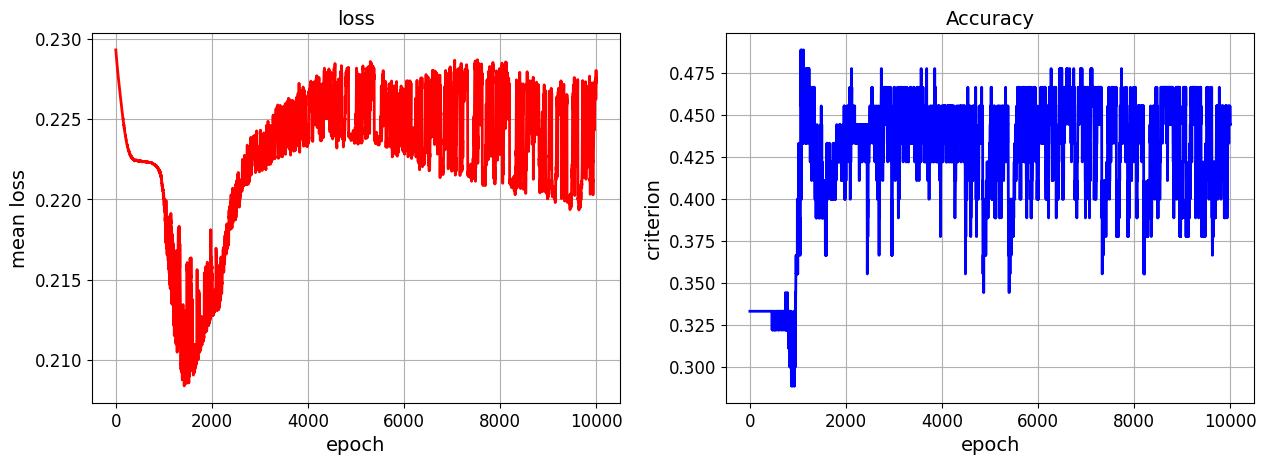

In [58]:
show_progress(loss, acc, 'loss', 'Accuracy')

In [80]:
criterion = nn.MSELoss()# nn.BCEWithLogitsLoss(pos_weight=torch.tensor(3))# weight=torch.tensor([1, 4], device=my_device)

learning_params = {
    'num_epochs' : 10000,
    'lr' : 1e-4,
    'weight_decay' : 1e-2,
    'step_size' : 5,
    'gamma' : 1,
    'num_classes' : 2,
    'model_type' : 'CNN'
  }

torch.manual_seed(44)
np.random.seed(44)

my_device = torch.device('cuda:0')#torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')
print(my_device)

#model_CNN = CNN1(72, n_channels=64)
A = torch.tensor(get_delaunay_graph(seed_montage).toarray()).to(my_device)
#B = B.to(my_device)
#model_CNN = BaseCNNAttn(72, 64)
#model_CNN = BaseCNNAttn(72, 64, num_filters=10)
model_GNN = BaseGNN(5, 62, A, time_kernel=3, num_classes=3)
#model_CNN = BaseCNN(72, 64)

loss, acc, total_time = train_model(model_GNN, data_loaders_CNN, criterion, learning_params, is_binary=False, device=my_device, log_rate=1000)

cuda:0
Epoch 999/9999
------------------------------------------------------------------------------------------------------------------------------------------------------
train	 Loss: 0.2104	 Min Acc: 0.3940	 Acc: 0.4342	 Max Acc: 0.4744	
val	 Loss: 0.2220	 Min Acc: 0.2359	 Acc: 0.3333	 Max Acc: 0.4307	
Epoch 1999/9999
------------------------------------------------------------------------------------------------------------------------------------------------------
train	 Loss: 0.2093	 Min Acc: 0.4382	 Acc: 0.4786	 Max Acc: 0.5191	
val	 Loss: 0.2181	 Min Acc: 0.2359	 Acc: 0.3333	 Max Acc: 0.4307	
Epoch 2999/9999
------------------------------------------------------------------------------------------------------------------------------------------------------
train	 Loss: 0.2008	 Min Acc: 0.4603	 Acc: 0.5009	 Max Acc: 0.5414	
val	 Loss: 0.1942	 Min Acc: 0.3856	 Acc: 0.4889	 Max Acc: 0.5922	
Epoch 3999/9999
---------------------------------------------------------------------------

In [81]:
count_parameters(model_GNN)

241

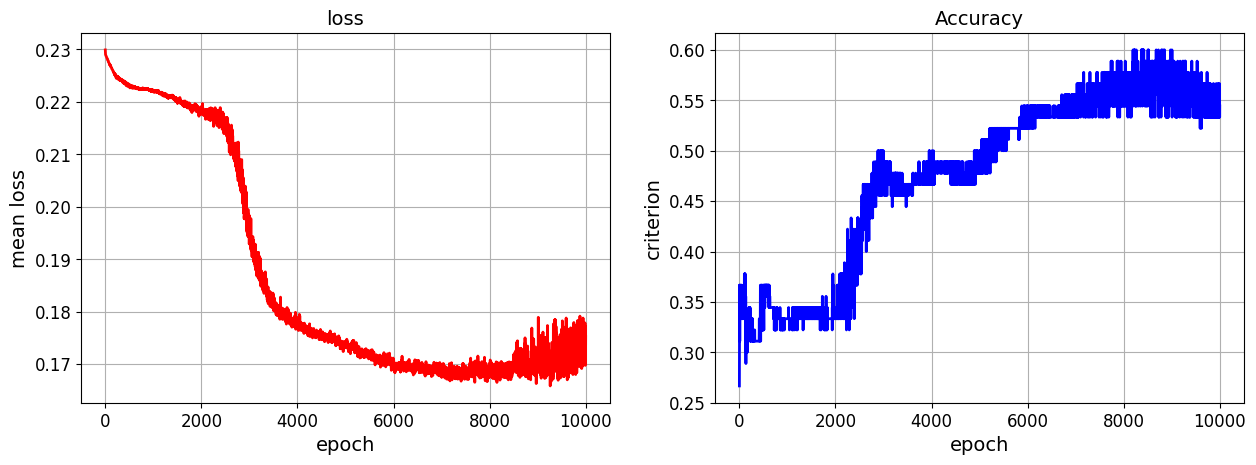

In [82]:
show_progress(loss, acc, 'loss', 'Accuracy')

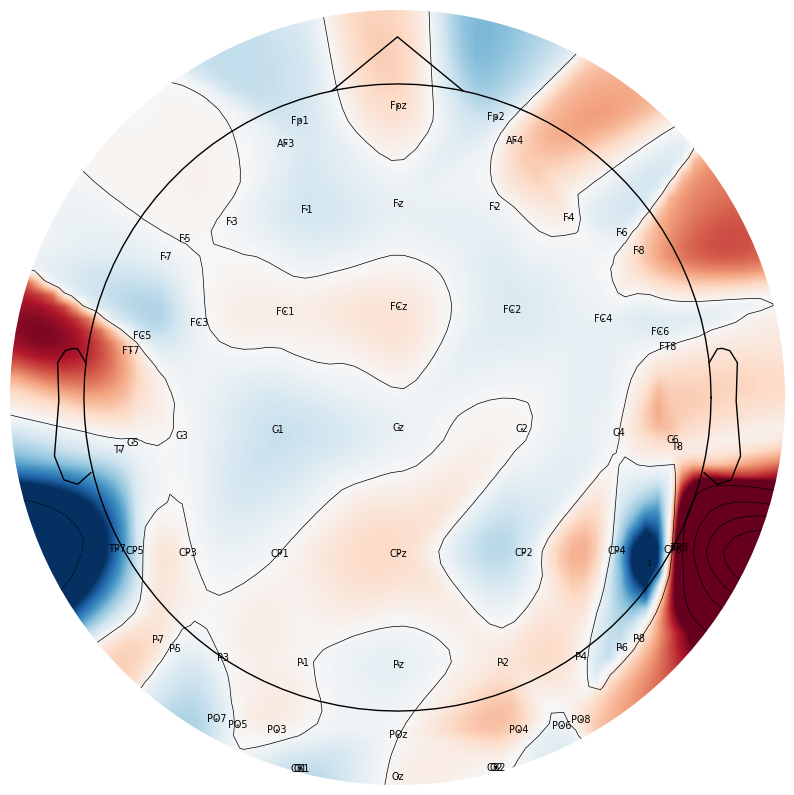

In [84]:
channel_weights = np.array(model_GNN.linear_channel.weight.flatten().detach().cpu())
mne.viz.plot_topomap(channel_weights, np.stack(seed_montage.get_positions()['ch_pos'].values())[:,:-1], size=10, 
                     names=seed_montage.ch_names) #, vmin=min(channel_weights), vmax=max(channel_weights)
plt.show()

In [15]:
criterion = nn.MSELoss()# nn.BCEWithLogitsLoss(pos_weight=torch.tensor(3))# weight=torch.tensor([1, 4], device=my_device)

learning_params = {
    'num_epochs' : 400,
    'lr' : 1e-4,
    'weight_decay' : 1e-2,
    'step_size' : 5,
    'gamma' : 1,
    'num_classes' : 2,
    'model_type' : 'CNN'
  }

torch.manual_seed(44)
np.random.seed(44)

my_device = torch.device('cuda:0')#torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')
print(my_device)

#model_CNN = CNN1(72, n_channels=64)
A = torch.tensor(get_delaunay_graph(eloc).toarray()).to(my_device)
#B = B.to(my_device)
#model_CNN = BaseCNNAttn(72, 64)
#model_CNN = BaseCNNAttn(72, 64, num_filters=10)
#model_GNN = BaseGNN(48, 64, A)
model_CNN = BaseCNN(48, 64)

loss, acc, total_time = train_model(model_CNN, data_loaders_CNN, criterion, learning_params, device=my_device, log_rate=10)

cuda:0
Epoch 9/399
------------------------------------------------------------------------------------------------------------------------------------------------------
train	 Loss: 0.2522	 Min Acc: 0.4935	 Acc: 0.4996	 Max Acc: 0.5057	 Balanced Acc: 0.4996	 Positive: 397.1667	 Precision: 0.4995	 Recall: 0.3734	 F1-score: 0.4273	
val	 Loss: 0.2480	 Min Acc: 0.5684	 Acc: 0.5756	 Max Acc: 0.5828	 Balanced Acc: 0.4994	 Positive: 408.7647	 Precision: 0.1662	 Recall: 0.3850	 F1-score: 0.2322	
Epoch 19/399
------------------------------------------------------------------------------------------------------------------------------------------------------
train	 Loss: 0.2495	 Min Acc: 0.5225	 Acc: 0.5286	 Max Acc: 0.5347	 Balanced Acc: 0.5286	 Positive: 527.0417	 Precision: 0.5288	 Recall: 0.5246	 F1-score: 0.5267	
val	 Loss: 0.2493	 Min Acc: 0.5143	 Acc: 0.5216	 Max Acc: 0.5289	 Balanced Acc: 0.5207	 Positive: 513.4118	 Precision: 0.1785	 Recall: 0.5193	 F1-score: 0.2657	
Epoch 29/399
-----

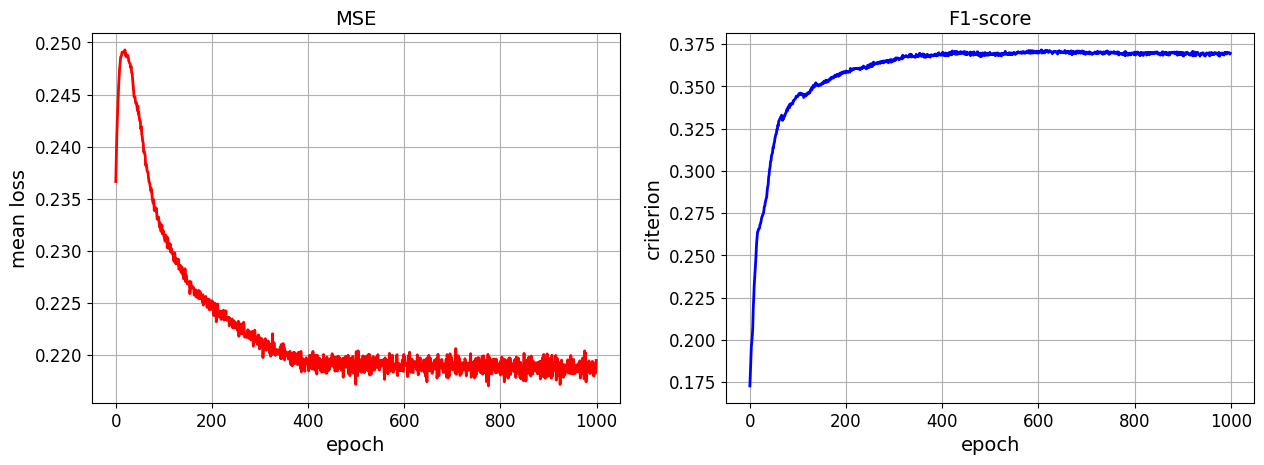

In [17]:
show_progress(loss, acc, 'MSE', 'F1-score')

In [ ]:
np.save('weights/gnn_linear_sum.npy', np.array(model_GNN.linear_channel.weight.flatten().detach().cpu())) 

In [70]:
criterion = nn.MSELoss()# nn.BCEWithLogitsLoss(pos_weight=torch.tensor(3))# weight=torch.tensor([1, 4], device=my_device)

learning_params = {
    'num_epochs' : 1000,
    'lr' : 1e-4,
    'weight_decay' : 1e-2,
    'step_size' : 5,
    'gamma' : 1,
    'num_classes' : 2,
    'model_type' : 'CNN'
  }

torch.manual_seed(44)
np.random.seed(44)

my_device = torch.device('cuda:0')#torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')
print(my_device)

#model_CNN = CNN1(72, n_channels=64)
A = torch.tensor(get_delaunay_graph(eloc).toarray()).to(my_device)
#B = B.to(my_device)
#model_CNN = BaseCNNAttn(72, 64)
#model_CNN = BaseCNNAttn(72, 64, num_filters=10)
model_GNN = BaseGNNBig(72, 64, A)

loss, acc, total_time = train_model(model_GNN, data_loaders_CNN, criterion, learning_params, device=my_device, log_rate=10)

cuda:0
Epoch 9/999
------------------------------------------------------------------------------------------------------------------------------------------------------
train	 Loss: 0.2457	 Acc: 0.5536	 Balanced Acc: 0.5536	 Positive: 481.5833	 Precision: 0.5592	 Recall: 0.5069	 F1-score: 0.5318	
val	 Loss: 0.2425	 Acc: 0.5771	 Balanced Acc: 0.5330	 Positive: 436.1765	 Precision: 0.1889	 Recall: 0.4670	 F1-score: 0.2690	
Epoch 19/999
------------------------------------------------------------------------------------------------------------------------------------------------------
train	 Loss: 0.2368	 Acc: 0.5998	 Balanced Acc: 0.5998	 Positive: 527.7917	 Precision: 0.6005	 Recall: 0.5965	 F1-score: 0.5985	
val	 Loss: 0.2399	 Acc: 0.5841	 Balanced Acc: 0.5678	 Positive: 455.7059	 Precision: 0.2104	 Recall: 0.5433	 F1-score: 0.3033	
Epoch 29/999
---------------------------------------------------------------------------------------------------------------------------------------------

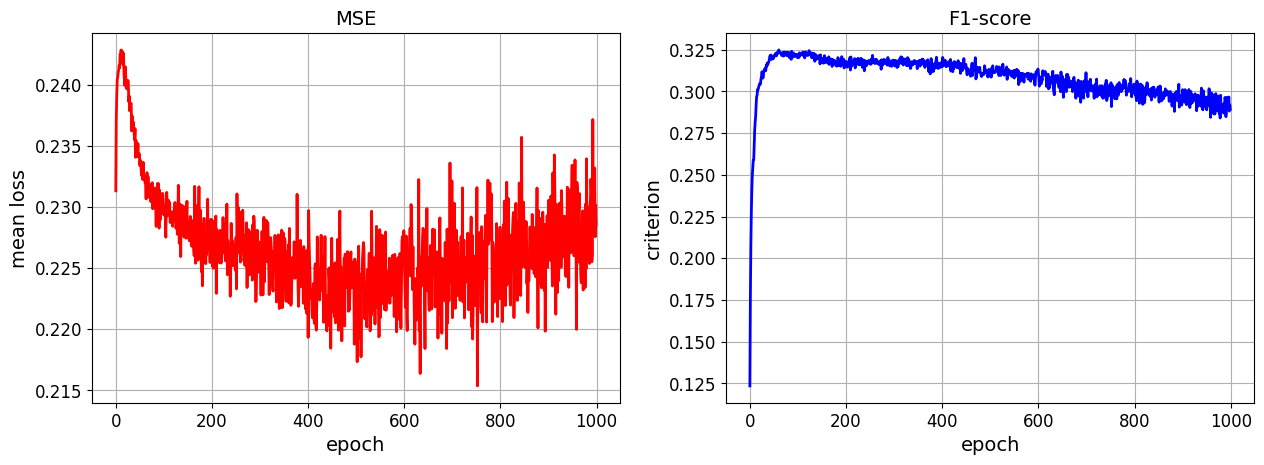

In [71]:
show_progress(loss, acc, 'MSE', 'F1-score')

In [72]:
criterion = nn.MSELoss()# nn.BCEWithLogitsLoss(pos_weight=torch.tensor(3))# weight=torch.tensor([1, 4], device=my_device)

learning_params = {
    'num_epochs' : 100,
    'lr' : 1e-4,
    'weight_decay' : 1e-2,
    'step_size' : 5,
    'gamma' : 1,
    'num_classes' : 2,
    'model_type' : 'CNN'
  }

torch.manual_seed(44)
np.random.seed(44)

my_device = torch.device('cuda:0')#torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')
print(my_device)

#model_CNN = CNN1(72, n_channels=64)
A = torch.tensor(get_delaunay_graph(eloc).toarray()).to(my_device)
#B = B.to(my_device)
#model_CNN = BaseCNNAttn(72, 64)
#model_CNN = BaseCNNAttn(72, 64, num_filters=10)
model_GNN = STGCN(72, 64, A)

loss, acc, total_time = train_model(model_GNN, data_loaders_CNN, criterion, learning_params, device=my_device, log_rate=10)

cuda:0
Epoch 9/999
------------------------------------------------------------------------------------------------------------------------------------------------------
train	 Loss: 0.2359	 Acc: 0.6119	 Balanced Acc: 0.6119	 Positive: 581.6667	 Precision: 0.6022	 Recall: 0.6594	 F1-score: 0.6295	
val	 Loss: 0.2243	 Acc: 0.6253	 Balanced Acc: 0.5996	 Positive: 418.2353	 Precision: 0.2367	 Recall: 0.5610	 F1-score: 0.3329	
Epoch 19/999
------------------------------------------------------------------------------------------------------------------------------------------------------
train	 Loss: 0.2149	 Acc: 0.6670	 Balanced Acc: 0.6670	 Positive: 548.0833	 Precision: 0.6619	 Recall: 0.6828	 F1-score: 0.6722	
val	 Loss: 0.2272	 Acc: 0.6187	 Balanced Acc: 0.6245	 Positive: 450.8235	 Precision: 0.2479	 Recall: 0.6333	 F1-score: 0.3563	
Epoch 29/999
---------------------------------------------------------------------------------------------------------------------------------------------

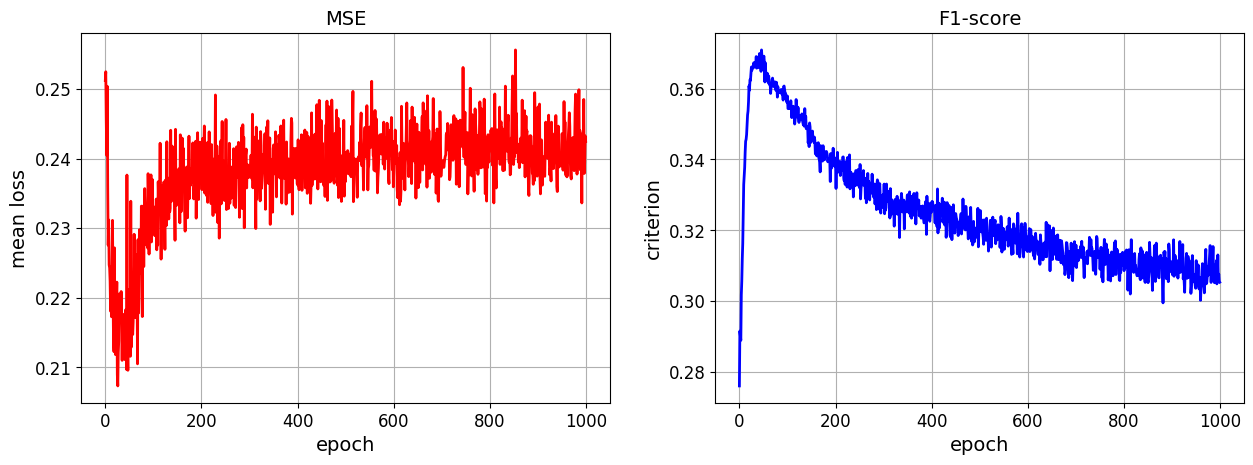

In [73]:
show_progress(loss, acc, 'MSE', 'F1-score')

In [9]:
criterion = nn.MSELoss()# nn.BCEWithLogitsLoss(pos_weight=torch.tensor(3))# weight=torch.tensor([1, 4], device=my_device)

learning_params = {
    'num_epochs' : 400,
    'lr' : 1e-4,
    'weight_decay' : 1e-2,
    'step_size' : 5,
    'gamma' : 1,
    'num_classes' : 2,
    'model_type' : 'CNN'
  }

torch.manual_seed(44)
np.random.seed(44)

my_device = torch.device('cuda:0')#torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')
print(my_device)

#model_CNN = CNN1(72, n_channels=64)
A = torch.tensor(get_delaunay_graph(eloc).toarray()).to(my_device)
#B = B.to(my_device)
#model_CNN = BaseCNNAttn(72, 64)
#model_CNN = BaseCNNAttn(72, 64, num_filters=10)
model_CNN = BaseCNN(72, 64)

loss, acc, total_time = train_model(model_CNN, data_loaders_CNN, criterion, learning_params, device=my_device, log_rate=10)

cuda:0
Epoch 9/399
------------------------------------------------------------------------------------------------------------------------------------------------------
train	 Loss: 0.2498	 Min Acc: 0.5201	 Acc: 0.5263	 Max Acc: 0.5324	 Balanced Acc: 0.5263	 Positive: 667.0833	 Precision: 0.5209	 Recall: 0.6541	 F1-score: 0.5800	
val	 Loss: 0.2557	 Min Acc: 0.4261	 Acc: 0.4334	 Max Acc: 0.4406	 Balanced Acc: 0.5196	 Positive: 652.5294	 Precision: 0.1755	 Recall: 0.6490	 F1-score: 0.2763	
Epoch 19/399
------------------------------------------------------------------------------------------------------------------------------------------------------
train	 Loss: 0.2450	 Min Acc: 0.5598	 Acc: 0.5658	 Max Acc: 0.5719	 Balanced Acc: 0.5658	 Positive: 631.6250	 Precision: 0.5554	 Recall: 0.6603	 F1-score: 0.6033	
val	 Loss: 0.2528	 Min Acc: 0.4827	 Acc: 0.4900	 Max Acc: 0.4973	 Balanced Acc: 0.5503	 Positive: 589.6471	 Precision: 0.1917	 Recall: 0.6407	 F1-score: 0.2951	
Epoch 29/399
-----

In [ ]:
Min Acc: 0.6385	 Acc: 0.6454	 Max Acc: 0.6524 0.7
Min Acc: 0.6117	 Acc: 0.6188	 Max Acc: 0.6259 0.7

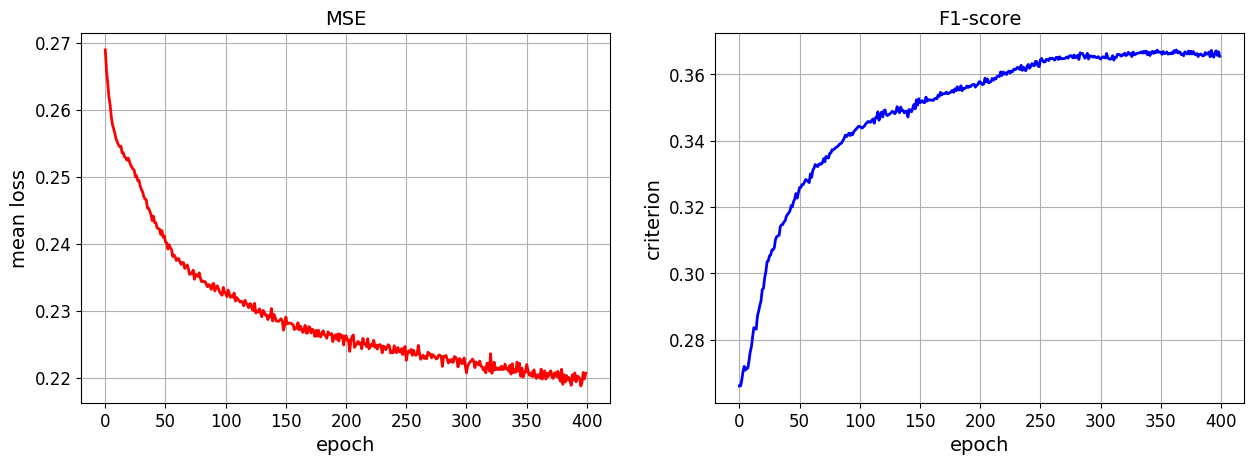

In [10]:
show_progress(loss, acc, 'MSE', 'F1-score')

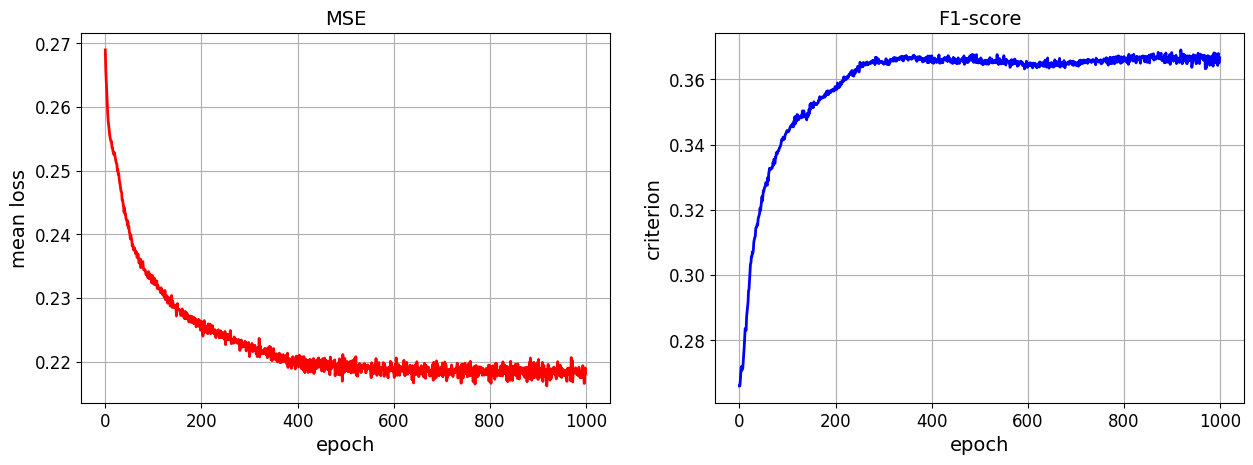

In [77]:
show_progress(loss, acc, 'MSE', 'F1-score')

In [133]:
criterion = nn.MSELoss()# nn.BCEWithLogitsLoss(pos_weight=torch.tensor(3))# weight=torch.tensor([1, 4], device=my_device)

learning_params = {
    'num_epochs' : 100,
    'lr' : 1e-4,
    'weight_decay' : 1e-2,
    'step_size' : 5,
    'gamma' : 1,
    'num_classes' : 2,
    'model_type' : 'CNN'
  }

torch.manual_seed(44)
np.random.seed(44)

my_device = torch.device('cuda:0')#torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')
print(my_device)

#model_CNN = CNN1(72, n_channels=64)
A = torch.tensor(get_delaunay_graph(eloc).toarray()).to(my_device)
#B = B.to(my_device)
#model_CNN = BaseCNNAttn(72, 64)
#model_CNN = BaseCNNAttn(72, 64, num_filters=10)
model_GNN = BaseGNN(72, 64, A)

loss, acc, total_time = train_model(model_GNN, data_loaders_CNN_B, criterion, learning_params, device=my_device, log_rate=10)

cuda:0
Epoch 9/99
------------------------------------------------------------------------------------------------------------------------------------------------------
train	 Loss: 0.2456	 Min Acc: 0.5574	 Acc: 0.5635	 Max Acc: 0.5696	 Balanced Acc: 0.5635	 Positive: 453.1250	 Precision: 0.5744	 Recall: 0.4900	 F1-score: 0.5288	
val	 Loss: 0.2386	 Min Acc: 0.6005	 Acc: 0.6077	 Max Acc: 0.6148	 Balanced Acc: 0.5598	 Positive: 411.1765	 Precision: 0.2094	 Recall: 0.4880	 F1-score: 0.2931	
Epoch 19/99
------------------------------------------------------------------------------------------------------------------------------------------------------
train	 Loss: 0.2316	 Min Acc: 0.6160	 Acc: 0.6220	 Max Acc: 0.6280	 Balanced Acc: 0.6220	 Positive: 554.4583	 Precision: 0.6169	 Recall: 0.6438	 F1-score: 0.6301	
val	 Loss: 0.2380	 Min Acc: 0.5978	 Acc: 0.6049	 Max Acc: 0.6121	 Balanced Acc: 0.6124	 Positive: 461.9412	 Precision: 0.2383	 Recall: 0.6237	 F1-score: 0.3448	
Epoch 29/99
--------

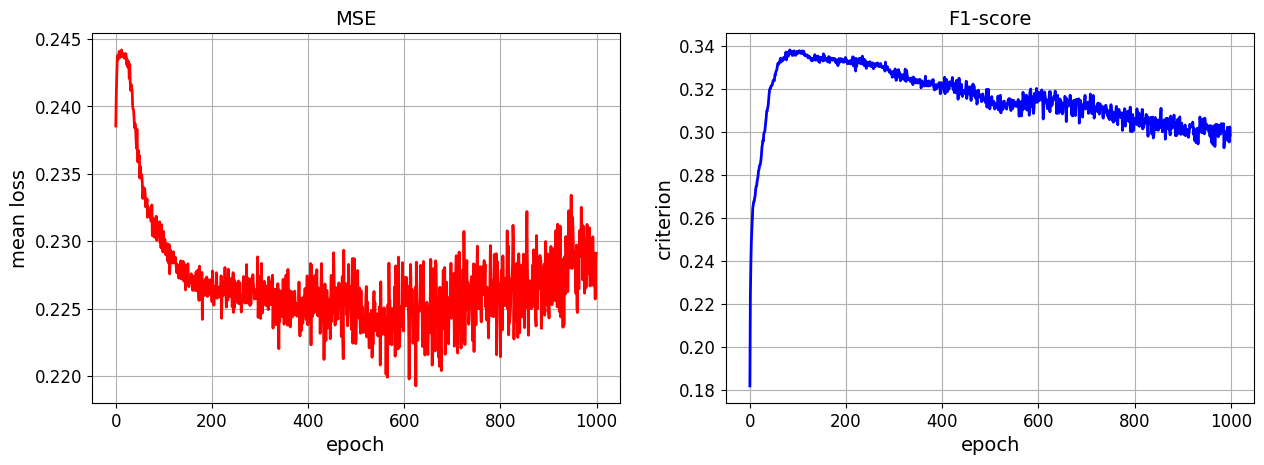

In [120]:
show_progress(loss, acc, 'MSE', 'F1-score')

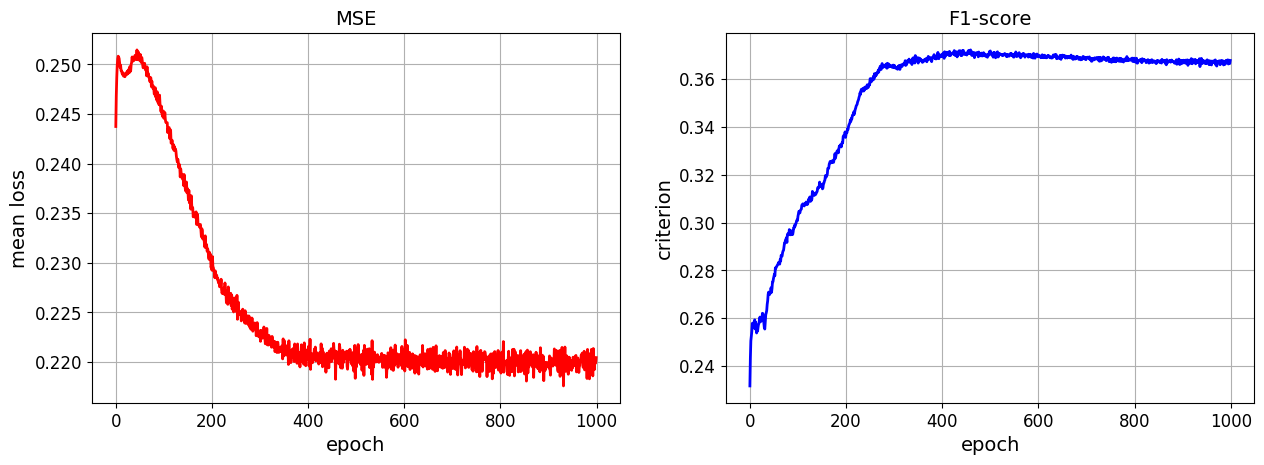

In [117]:
show_progress(loss, acc, 'MSE', 'F1-score')

In [118]:
import sys
sys.path.append('../src')

from data import GraphMatrixDataset, CNNMatrixDataset
from utils import P300Getter, train_model, plot_sample, show_progress, count_parameters
from interpretation import *
from models_cnn import *
from models_gnn import *
from graph import get_delaunay_graph

/home/leonid/.cache/pypoetry/virtualenvs/pattern-recognition-c2sUhGwq-py3.10/lib/python3.10/site-packages/IPython/core/interactiveshell.py:3445: FutureWarning: arrays to stack must be passed as a "sequence" type such as list or tuple. Support for non-sequence iterables such as generators is deprecated as of NumPy 1.16 and will raise an error in the future.
  if await self.run_code(code, result, async_=asy):


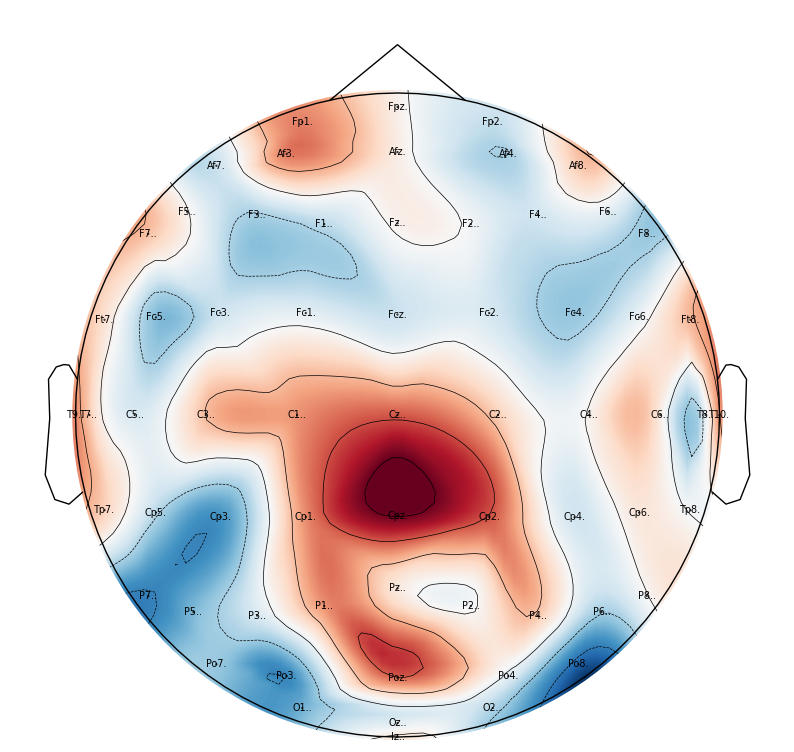

In [114]:
channel_weights = np.array(model_GNN.linear_channel.weight.flatten().detach().cpu())
mne.viz.plot_topomap(channel_weights, np.stack(eloc.get_positions()['ch_pos'].values())[:,:-1], size=10, 
                     names=eloc.ch_names) #, vmin=min(channel_weights), vmax=max(channel_weights)
plt.show()

In [128]:
DATA_PATH = '../matrix_dataset/'

train_B_raw = scipy.io.loadmat(DATA_PATH + 'Subject_B_Train.mat')
test_B_raw = scipy.io.loadmat(DATA_PATH + 'Subject_B_Test.mat')

eloc = mne.channels.read_custom_montage(DATA_PATH + 'eloc64.loc')
info = mne.create_info(ch_names=eloc.ch_names, ch_types=['eeg'] * 64, sfreq=240)

In [129]:
train_B_chars = list(train_B_raw['TargetChar'][0])
test_B_chars = list('MERMIROOMUHJPXJOHUVLEORZP3GLOO7AUFDKEFTWEOOALZOP9ROCGZET1Y19EWX65QUYU7NAK_4YCJDVDNGQXODBEV2B5EFDIDNR')

In [130]:
B_train_ds = P300Getter(train_B_raw, eloc)
B_test_ds = P300Getter(test_B_raw, eloc, target_chars=test_B_chars)

B_train_ds.get_cnn_p300_dataset(filter=True)
B_test_ds.get_cnn_p300_dataset(filter=True)
B_train_ds.upsample(4)

100%|█████████████████████████████████████████| 100/100 [00:04<00:00, 20.61it/s]


In [131]:
X_train_B, y_train_B = B_train_ds.get_data()
X_test_B, y_test_B = B_test_ds.get_data()

In [132]:
train_B_dataset = CNNMatrixDataset(tensors=(X_train_B, y_train_B), with_target=True, transform=None)
test_B_dataset = CNNMatrixDataset(tensors=(X_test_B, y_test_B), with_target=True, transform=None)

batch_size = 1024 #256

train_B_CNN = DataLoader(train_B_dataset, batch_size=batch_size) # , shuffle=True
test_B_CNN = DataLoader(test_B_dataset, batch_size=batch_size) # , shuffle=True

data_loaders_CNN_B = {'train':train_B_CNN, 'val':test_B_CNN}